In [91]:
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import os

## Setup

In [92]:
def create_directory(head_directory_name, structure_number):
    directory = os.path.join(head_directory_name, str(structure_number))
    os.makedirs(directory)
    return directory

In [114]:
# Define number of structures
num_struct_in_fit = 5 #How many structures are in the fit

# Create cross validation directory
head_directory_name = 'final_potentials/formal+ri'
# head_directory_name = 'scale_testing/scale_0.1'
plot_directory_name = 'plots'
head_output_directory = create_directory(head_directory_name, plot_directory_name)

## This section plots the errors of each structure
Firstly the errors are read in from the sub directories into a dictionary, converting the error to a float and using the directory path as the structure number by removing the error file extention. This won't work for a directory tree, only for a depth of 1.

In [107]:
error_dict = {}
for error_file in sorted(glob.glob('{}/*/error.dat'.format(head_directory_name))):
    error = float(np.loadtxt(error_file))
    structure_num = error_file.replace('/error.dat', '').replace('{}/'.format(head_directory_name), '')
    error_dict.update( {structure_num:error}) #Remove int if directory naming system changes to include strings. This will change the order of the structures though.

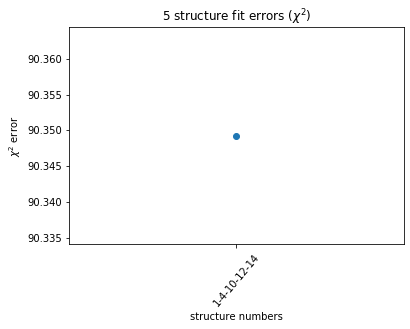

In [108]:
plt.scatter(*zip(*sorted(error_dict.items())))
plt.xticks(rotation=50)
plt.xlabel('structure numbers')
plt.ylabel('$\chi^2$ error')
plt.title('{} structure fit errors ($\chi^2$)'.format(num_struct_in_fit))
# plt.savefig('{}/{}_structure_fit_errors.png'.format(head_output_directory, num_struct_in_fit),dpi=500, bbox_inches = "tight")
plt.show()

## This section plots the separate potential parameters for each structure
Firstly the potentials are read in as a dictionary from each structures potentials.json file, these are edited to include the structure number, then appended to a list of potential dictionaries. These dictionaries are then combined to have all structures in one dictionary, where the keys are the potential name and the values are the tuples containing structure number and value. These are then plotted in individual plots by potential.

In [109]:
list_of_dict = []
for potential_file in sorted(glob.glob('{}/*/potentials.json'.format(head_directory_name))):
    with open(potential_file, 'r') as f:
        potentials = json.load(f)
    structure_num = potential_file.replace('/potentials.json', '').replace('{}/'.format(head_directory_name), '')
    potentials.update((k, (structure_num,v) ) for k,v in potentials.items()) #Remove int if directory naming system changes to include strings. This will change the order of the structures though.
    list_of_dict.append(potentials)

In [110]:
potentials_dict = {}
for key in list_of_dict[0].keys():
    potentials_dict[key] = [potentials_dict[key] for potentials_dict in list_of_dict]

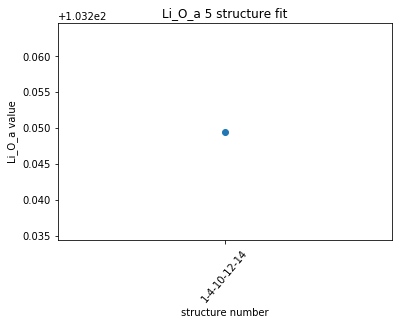

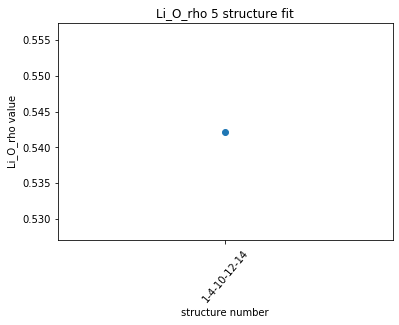

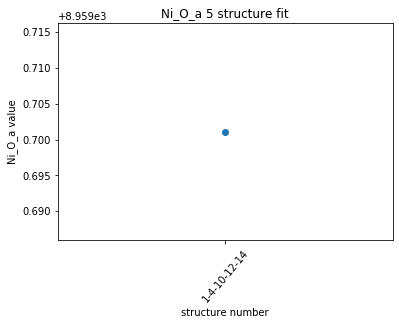

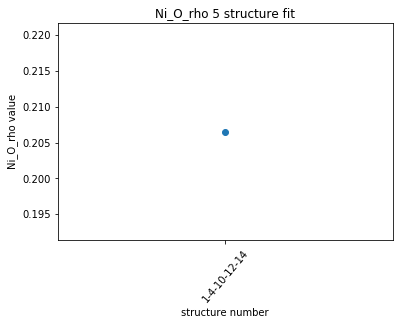

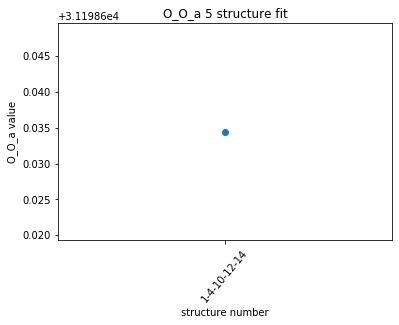

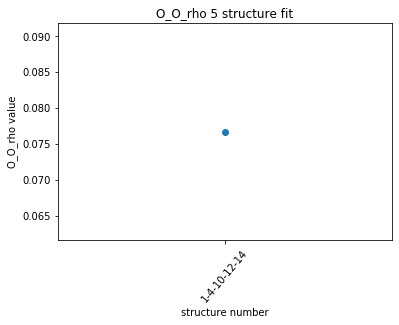

In [111]:
for k,v in potentials_dict.items():
    x_val = [x[0] for x in v]
    y_val = [y[1] for y in v]
    plt.scatter(x_val,y_val)
    plt.xticks(rotation=50)
    plt.xlabel('structure number')
    plt.ylabel('{} value'.format(k))
    plt.title('{} {} structure fit'.format(k, num_struct_in_fit))
#     plt.savefig('{}/{}_structure_fit_{}.png'.format(head_output_directory, num_struct_in_fit, k) ,dpi=500, bbox_inches = "tight")
    plt.show()

## Plot forces and stresses

In [113]:
structure_num = "1-4-10-12-14"
for structure in sorted(glob.glob('{}/{}'.format(head_directory_name, structure_num))):
    dft_forces = np.loadtxt('{}/dft_forces.dat'.format(structure), delimiter=' ')
    ip_forces = np.loadtxt('{}/ip_forces.dat'.format(structure), delimiter=' ')
    dft_stresses = np.loadtxt('{}/dft_stresses.dat'.format(structure), delimiter=' ')
    ip_stresses = np.loadtxt('{}/ip_stresses.dat'.format(structure), delimiter=' ')

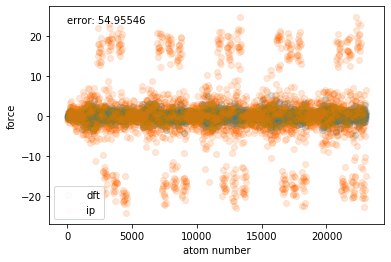

In [116]:
x= np.arange(0, len(dft_forces.flatten()))
plt.scatter(x, dft_forces.flatten(), label='dft', alpha=0.02)
plt.scatter(x, ip_forces.flatten(), label='ip', alpha=0.02)
plt.legend()
# plt.xticks(rotation=50)
plt.xlabel('atom number')
plt.ylabel('force')
plt.text(0,4.5, 'error: {0:.5f}'.format(np.sum((dft_forces - ip_forces)**2)/ dft_forces.size))
plt.savefig('{}/forces.png'.format(head_output_directory),dpi=500, bbox_inches = "tight")
plt.show()

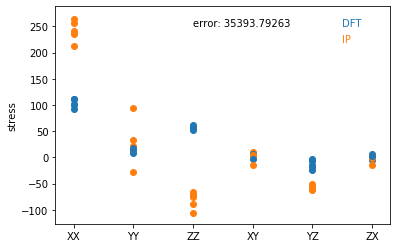

In [118]:
x= ['XX', 'YY', 'ZZ', 'XY', 'YZ', 'ZX'] 
dft_y = dft_stresses.reshape(5, 6)
ip_y = ip_stresses.reshape(5,6)
for dy, iy in zip(dft_y, ip_y):
    plt.scatter(x, dy, label='dft', color='tab:blue')
    plt.scatter(x, iy , label='ip', color='tab:orange')
# plt.legend()
# plt.xticks(rotation=50)
plt.ylabel('stress')
plt.text(2,250, 'error: {0:.5f}'.format(np.sum((dft_stresses - ip_stresses)**2)/ 6))
plt.text(4.5,250, 'DFT', color='tab:blue')
plt.text(4.5,220, 'IP', color='tab:orange')
plt.savefig('{}/stresses.png'.format(head_output_directory),dpi=500, bbox_inches = "tight")
plt.show()

In [119]:
force_diff = np.sum((dft_forces - ip_forces)**2)/ dft_forces.size
stress_diff = np.sum((dft_stresses - ip_stresses)**2)/ 6
force_diff+(stress_diff*0.001)

90.34925017275276